# Imports

In [81]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import librosa
import utils
from scipy import stats
import pyroomacoustics as pra
from network_lib import EndToEndLocModel
from tqdm import tqdm
from params import fs, window_size, min_src, max_src,n_mic, mics, c, composite
from utils import normalize, denormalize
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 15})


# Params

In [185]:
SNR = 20
T60=0.3
data_path = '/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/dataset2/val'
data_path = '/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/dataset2/test/SNR_'+str(SNR)+'_T60_'+str(T60)
files = [os.path.join(data_path,path) for path in os.listdir(data_path)]

In [186]:
# Load network model
saved_model_path='/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/models/model_SNR_'+str(SNR)+'_T60_'+str(T60)+'.pth'
model = EndToEndLocModel()
model.load_state_dict(torch.load(saved_model_path))
model.eval()

EndToEndLocModel(
  (conv1): Conv1d(16, 96, kernel_size=(7,), stride=(1,), padding=same)
  (conv2): Conv1d(96, 96, kernel_size=(7,), stride=(1,), padding=same)
  (conv3): Conv1d(96, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv4): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3712, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
  (dr1): Dropout1d(p=0.5, inplace=False)
  (activation1): ReLU()
  (activation2): ReLU()
  (activation3): ReLU()
  (activation4): ReLU()
  (activation5): ReLU()
  (activation6): ReLU()
)

In [316]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Network parameters: '+str(count_parameters(model)))

Number of Network parameters: 2126355


# Source Localization

### Localize one random source

In [188]:
idx_file = np.random.randint(0,len(files))
data_structure = np.load(str(files[idx_file]))
win_sig = data_structure['win_sig']
N_wins = win_sig.shape[-1]
idx_slice = np.random.randint(0,N_wins)
input_win_sig = win_sig[:,:,idx_slice]
src_loc_gt = data_structure['src_pos']

In [189]:
with torch.no_grad():
    est_pos = model(torch.Tensor(input_win_sig).unsqueeze(0))

0.11601216100380579


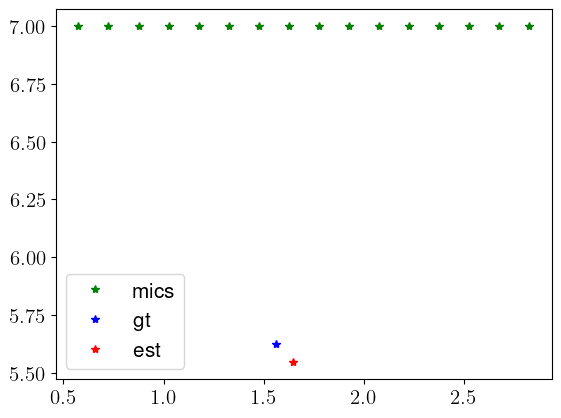

In [190]:

est_pos = est_pos.detach().numpy()[0]

plt.figure()
plt.plot(mics[0,:],mics[1,:],'g*')
plt.plot(src_loc_gt[0],src_loc_gt[1],'b*')
plt.plot(est_pos[0],est_pos[1],'r*')
plt.legend(['mics','gt','est'])

print(str(np.linalg.norm(est_pos-src_loc_gt)))

### Localize all sources per each window

In [191]:
sources_est = []
sources_gt = []
N_sources = len(files)
for n_s in tqdm(range(len(files))):
    data_structure = np.load(str(files[n_s]))
    win_sig = data_structure['win_sig']

    N_wins = win_sig.shape[-1]
    sources_win = []

    for n_w in range(N_wins):
        input_win_sig = win_sig[:,:,n_w]
        with torch.no_grad():
            est_pos = model(torch.Tensor(input_win_sig).unsqueeze(0)).detach().numpy()[0]
        sources_est.append(est_pos)
        sources_gt.append(data_structure['src_pos'])
sources_est = np.array(sources_est)
sources_gt = np.array(sources_gt)


 ... (more hidden) ...


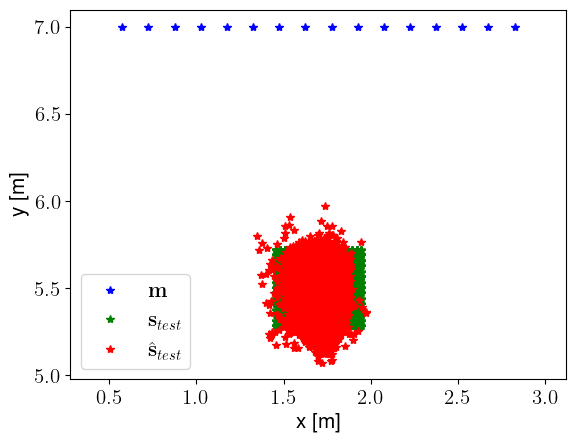

In [192]:
plt.figure()
plt.plot(mics[0,:],mics[1,:],'b*')
plt.plot(sources_gt[:,0],sources_gt[:,1],'g*')
plt.plot(sources_est[:,0],sources_est[:,1],'r*')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.legend(['$\mathbf{m}$','$\mathbf{s}_{test}$','$\hat{\mathbf{s}}_{test}$'], fontsize=15)
plt.axis('equal')
plt.show()


In [193]:
MAE = np.mean(np.mean(np.abs(sources_est-sources_gt),1))
print('MAE: '+str(MAE)+ '[m]')

MAE: 0.10374540494741245[m]


# Input Feature Inspection (LRP)

In [288]:
# Extract one random source
n_s = np.random.randint(len(files))
#n_s = 29 # N.B. Fixed if you want to reproduce paper exact same results!!!!!!
data_structure = np.load(str(files[n_s]))
win_sig = data_structure['win_sig']
sources_gt[n_s] = data_structure['src_pos']
N_wins = win_sig.shape[-1]


In [310]:
sources_gt[n_s]

array([1.48125   , 5.375     , 1.33693965])

In [289]:
data = torch.permute(torch.Tensor(win_sig),(2,0,1))
output_gt = torch.unsqueeze(torch.Tensor(sources_gt[n_s] ),0)
output_gt = output_gt.repeat(N_wins,1)

In [290]:
# Apply LRP
with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(data, output_gt)

data = data.detach().numpy()
relevance = relevance.detach().numpy()

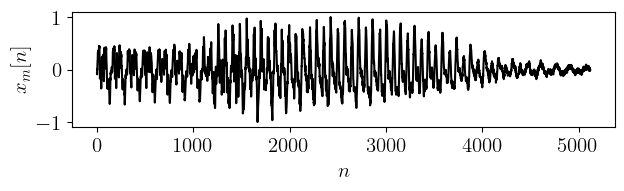

In [291]:
# Plot single window 
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(data[1,0]),'k')
plt.xlabel('$n$')
plt.ylabel('$x_m[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_input.pdf',bbox_inches='tight')
plt.show()

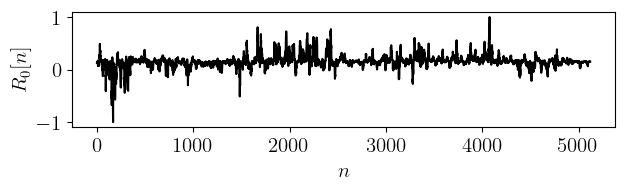

In [292]:
# Plot relevance map for the window
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(relevance[1,0]),'k')
plt.xlabel('$n$')
plt.ylabel('$R_0[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_relevance.pdf',bbox_inches='tight')

plt.show()

### GCC-PHAT visualization

In [293]:
idx_m1, idx_m2 = 6,9 # Microphone indices
audio_signal = data_structure['signal'][0] # In

# Reshape signal arriving at mic 1
win_sig_mic = data_structure['win_sig'][idx_m1]
win_sig_mic = np.transpose(win_sig_mic)
win_signal1 = np.reshape(win_sig_mic,window_size*N_wins)

# Reshape signal arriving at mic 2
win_sig_mic = data_structure['win_sig'][idx_m2]
win_sig_mic = np.transpose(win_sig_mic)
win_signal2 = np.reshape(win_sig_mic,window_size*N_wins) 

# Reshape relevance relative to signal at mic 1
relevance_mic = relevance[:,idx_m1]
lrp_signal1 = np.reshape(relevance_mic,window_size*N_wins)

# Reshape relevance relative to signal at mic 2
relevance_mic = relevance[:,idx_m2]
lrp_signal2 = np.reshape(relevance_mic,window_size*N_wins)

# Compute STFT of signal
WIN_STFT = librosa.stft((win_signal1))
LRP_STFT = librosa.stft((lrp_signal1))


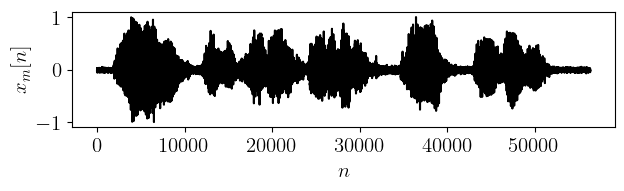

In [294]:
# Audio at microphones (reshaped to stack together different windows)
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(win_signal1),'k')
plt.xlabel('$n$')
plt.ylabel('$x_m[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_input_full.pdf',bbox_inches='tight')
plt.show()

/tmp/ipykernel_2625186/1412976144.py:3: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(WIN_STFT+1e-9), x_axis='time', y_axis='log', sr=fs,cmap='viridis')


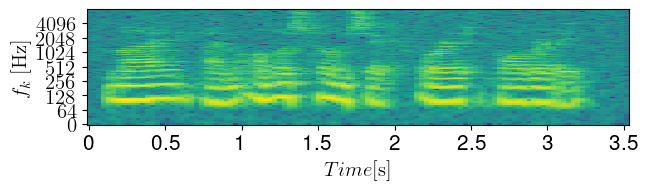

In [295]:
# STFT of audio at microphones
plt.figure(figsize=(7,1.5))
librosa.display.specshow(librosa.power_to_db(WIN_STFT+1e-9), x_axis='time', y_axis='log', sr=fs,cmap='viridis')
plt.xlabel('$Time [\mathrm{s}]$')
plt.ylabel('$f_k~[\mathrm{Hz}]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_stft_input.pdf',bbox_inches='tight')


In [296]:
import IPython.display as ipd
ipd.Audio(win_signal1, rate=fs) # load a NumPy array


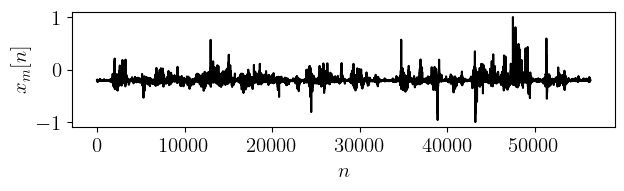

In [297]:
# Relevance at microphone (reshaped to stack together different windows)
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(lrp_signal1),'k')
plt.xlabel('$n$')
plt.ylabel('$x_m[n]$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,0))
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_relevance_full.pdf',bbox_inches='tight')
plt.show()

/tmp/ipykernel_2625186/3523326894.py:4: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(LRP_STFT), y_axis='log',x_axis='time', sr=fs,cmap='viridis')


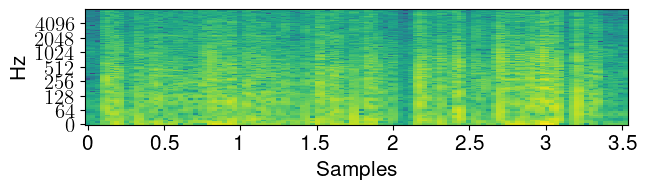

In [298]:
# STFT of Relevance at microphone 

plt.figure(figsize=(7,1.5))
librosa.display.specshow(librosa.power_to_db(LRP_STFT), y_axis='log',x_axis='time', sr=fs,cmap='viridis')
plt.xlabel('Samples')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_stft_relevance_input.pdf',bbox_inches='tight')
ipd.Audio(utils.normalize(lrp_signal1) , rate=fs) # load a NumPy array


In [299]:
# Compute GCC-PHAT
_, gcc_sig = utils.gcc_phat(win_signal1, win_signal2, fs=fs)
_, gcc_lrp = utils.gcc_phat(lrp_signal1, lrp_signal2, fs=fs)


In [300]:
# Ground-truth GCC-PHAT
gt_sig_1 = np.zeros_like(data[0,idx_m2])
gt_sig_2 = np.zeros_like(data[0,idx_m2])
dist_samples_1 = int((np.linalg.norm(sources_gt[n_s]  - mics[:,idx_m1])/c) * fs)
dist_samples_2 = int((np.linalg.norm(sources_gt[n_s]  - mics[:,idx_m2]) /c)*fs)
gt_sig_1[dist_samples_1] = 1/(4*np.pi*dist_samples_1)
gt_sig_2[dist_samples_2] = 1/(4*np.pi*dist_samples_2)
_, gcc_gt = utils.gcc_phat(gt_sig_2, gt_sig_1, fs=fs)



In [301]:
# Consider only samples contained in between mic distance
dist_mic_samples = (np.linalg.norm(mics[:,idx_m1]-mics[:,idx_m2])/c)*fs *2

gcc_sig_plot = gcc_sig[int(len(gcc_sig)/2 - dist_mic_samples):int(len(gcc_sig)/2+dist_mic_samples)]
gcc_lrp_plot = gcc_lrp[int(len(gcc_lrp)/2 - dist_mic_samples):int(len(gcc_lrp)/2+dist_mic_samples)]
gcc_gt_plot = gcc_gt[int(len(gcc_gt)/2 - dist_mic_samples):int(len(gcc_gt)/2+dist_mic_samples)]

ticks = ['$'+str(int(tick))+'$' for tick in np.arange(-dist_mic_samples,dist_mic_samples,dist_mic_samples*2/len(gcc_sig_plot))]

Text(0, 0.5, '$GCC-PHAT(\\ell)$')

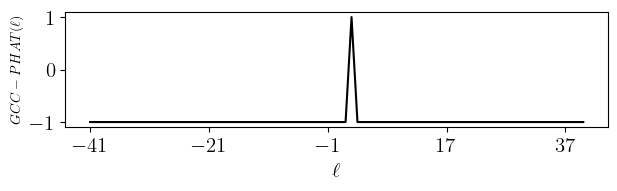

In [302]:
# Ground-truth GCC-PHAT
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(gcc_gt_plot),'k')
plt.xticks(np.arange(len(gcc_gt_plot))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)

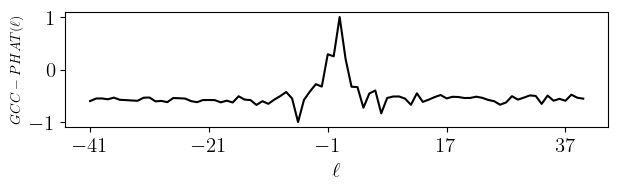

In [303]:
# LRP GCC-PHAT
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(gcc_lrp_plot),'k')
plt.xticks(np.arange(len(gcc_lrp_plot))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_gcc_relevance.pdf',bbox_inches='tight')


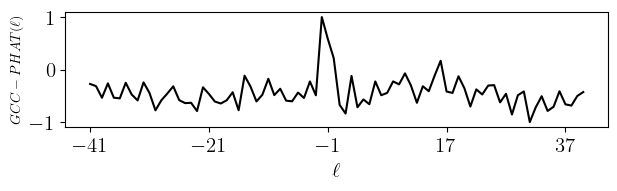

In [304]:
# Signal at microphones GCC-PHAT
plt.figure(figsize=(7,1.5))
plt.plot(utils.normalize(gcc_sig_plot),'k')
plt.xticks(np.arange(len(gcc_sig_plot))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_gcc_input.pdf',bbox_inches='tight')


In [306]:
# Time Delay estimation
print('Estimated time-delay')
print('(GT): ' +str(np.argmax(gcc_gt)-(len(gcc_gt)/2))+' samples')
print('(Microphone signals): ' +str(np.argmax(gcc_sig)-(len(gcc_sig)/2))+' samples')
print('(Relevance signals): ' +str(np.argmax(gcc_lrp)-(len(gcc_lrp)/2))+' samples')

Estimated time-delay
(GT): 1.5 samples
(Microphone signals): -3.5 samples
(Relevance signals): -0.5 samples
